This notebook introduces a transaction data simulator for generating legitimate and fraudulent transactions. It serves as a tool to evaluate fraud detection techniques effectively. Despite its simple design, the simulator replicates many real-world data challenges, including class imbalance, mixed features, complex relationships, and time-dependent fraud scenarios.

# Transaction Data Simulator

This simulator serves as a tool to evaluate fraud detection techniques effectively. Despite its simple design, the simulator replicates many real-world data challenges, including class imbalance, mixed features, complex relationships, and time-dependent fraud scenarios. The simulation involves 6 main steps which we will cover in-depth in this section, as illustrated in the diagram below:

![simulator](images/simulator.png)

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from tqdm.notebook import tqdm
import warnings

%matplotlib inline
pd.set_option('display.notebook_repr_html', True)
pd.DataFrame._repr_latex_ = lambda self: "\n".join([r'\begin{center}', self.to_latex(), r'\end{center}'])
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
warnings.filterwarnings('ignore')

## Customer Profiles Generation

Unique spending habits are simulated through customer attributes such as location, spending frequency, and spending amount, organized into `customer_profiles_table`. Each customer is characterized by:

- `CUSTOMER_ID`: A unique identifier for the customer.
- `(x_customer_id, y_customer_id)`: Real coordinates representing the customer's geographical location on a 100 * 100 grid.
- `(mean_amount, std_amount)`: The mean and standard deviation of transaction amounts for the customer
- `mean_nb_tx_per_day`: The average number of transactions per day for the customer

In [2]:
def generate_customer_profiles_table(n_customers, random_state=0):
    '''
    This function provides an implementation for generating a table of customer
    profiles. It takes as input the number of customers for which to generate a
    profile and a random state for reproducibility. It returns a DataFrame
    containing the properties for each customer.
    '''
    np.random.seed(random_state)
    customer_id_properties=[]

    # Generate customer properties from random distributions
    for customer_id in range(n_customers):
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        # Arbitrary (but sensible) values
        mean_amount = np.random.uniform(5,100)
        std_amount = mean_amount/2
        mean_nb_tx_per_day = np.random.uniform(0,4)
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])

    customer_profiles_table = pd.DataFrame(customer_id_properties, columns= [
            'CUSTOMER_ID',
            'x_customer_id', 'y_customer_id',
            'mean_amount', 'std_amount',
            'mean_nb_tx_per_day'])
    return customer_profiles_table

In [3]:
customer_profiles_table = generate_customer_profiles_table(n_customers=5)
customer_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,CUSTOMER-ID,x-customer-id,y-customer-id,mean-amount,std-amount,mean-nb-tx-per-day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


## Terminal Profiles Generation

Terminal characteristics represented in `terminal_profiles_table`, focus solely on geographical location. Each terminal will be defined by the following properties:

- `TERMINAL_ID`: The terminal ID
- `(x_terminal_id, y_terminal_id)`: A pair of real coordinates defining the geographical location of the terminal

In [4]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    '''
    This function provides an implementation for generating a table of terminal
    profiles. It takes as input the number of terminals for which to generate a
    profile and a random state for reproducibility. It returns a DataFrame
    containing the properties for each terminal.
    '''

    np.random.seed(random_state)
    terminal_id_properties=[]
    # Generate terminal properties from random distributions
    for terminal_id in range(n_terminals):
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])

    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=
        ['TERMINAL_ID', 'x_terminal_id', 'y_terminal_id'])
    return terminal_profiles_table

In [5]:
terminal_profiles_table = generate_terminal_profiles_table(n_terminals=5)
terminal_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,TERMINAL-ID,x-terminal-id,y-terminal-id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


## Association of Customer Profiles to Terminals

Customers are assumed to transact only at terminals within a certain radius `r` of their geographical location, reflected in the `available_terminals` feature added to each customer profile. Comparing the terminal locations stored in `terminal_profiles_table` and the customer locations in `customer_profiles_table`, we can compute the list of available terminals for a given customer at a given radius. The plot below demonstrates how the radius can affect the inclusion of surrounding terminals.

![available_terminals](images/available_terminals.png)

In [6]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    '''
    This function returns the list of terminals within a radius of r, given as
    input a customer profile (any row in the customer profiles table), an array
    containing the geographical location of all terminals, and the radius r.
    '''
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)

    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)

    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))

    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])

    # Return the list of terminal IDs
    return available_terminals

Calculating the available terminals for each customer can be performed using the pandas `apply` function. The results are stored as a new column named `available_terminals` in the customer profiles table.

In [7]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)

# Now we compute the available terminals
customer_profiles_table['available_terminals'] = \
    customer_profiles_table.apply(lambda x : \
        get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50),
        axis=1
    )
customer_profiles_table.rename(columns=lambda x: x.replace('_', '-'))

,CUSTOMER-ID,x-customer-id,y-customer-id,mean-amount,std-amount,mean-nb-tx-per-day,available-terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[0, 1, 2, 3]"
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[0, 1, 2, 3]"
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[1, 4]"
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[0, 1, 2, 3]"
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[2, 3]"


## Generation of Transactions

Transactions are generated based on customer attributes and terminal availability, resulting in a `transactions_df` table. We have now all the necessary information to generate the transactions, using the `generate_transactions_table` function below. This function will attempt to randomly populate the transaction data starting from a given date, until a certain number of days. Most of the values will be generated randomly, yet following a normal, uniform, or Poisson distribution.

We can verify that the generated transactions comply with the customer profile properties:
- `TERMINAL_ID`s correspond to those in the list of available terminals. However, not necessarily all these available terminals will be selected. As a result, the `available_terminals` is NOT equivalent to the actual terminals to which each customer is connected.
- `TX_AMOUNT`s appear to align with the customer's amount parameters represented as `mean_amount` and `std_amount`.
- The number of transactions per day varies based on the transaction frequency parameters of the customer, i.e. `mean_nb_tx_per_day`.

In [8]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    '''
    takes as input a customer profile, a starting date, and a number of days for
    which to generate transactions. It will return a table of transactions
    without considering the labels
    '''
    customer_transactions = []
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))

    # For all days
    for day in range(nb_days):
        # Random number of transactions for that day
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            for tx in range(nb_tx):
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))

                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    # Amount is drawn from a normal distribution
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)

                    amount=np.round(amount,decimals=2)
                    if len(customer_profile.available_terminals)>0:
                        terminal_id = random.choice(customer_profile.available_terminals)
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID,
                                                      terminal_id, amount])

    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    return customer_transactions

Now, let's generate transactions for all customers, which can be done straightforwardly using the pandas `groupby` and `apply` methods. This results in a set of 65 transactions, involving 5 customers, 5 terminals, and spanning across 5 days.

In [9]:
transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df.rename(columns=lambda x: x.replace('_', '-')).head()

,TX-DATETIME,CUSTOMER-ID,TERMINAL-ID,TX-AMOUNT,TX-TIME-SECONDS,TX-TIME-DAYS
0,2018-04-01 07:19:05,0,3,123.59,26345,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0
2,2018-04-01 18:00:16,0,0,77.34,64816,0
3,2018-04-02 15:13:02,0,2,32.35,141182,1
4,2018-04-02 14:05:38,0,3,63.30,137138,1


## Generation of Fraud Scenarios

In the final stage of the simulation, transactions are categorized as *legitimate* or *fraudulent* through the following scenarios:

- **Scenario 1:** Any transaction exceeding $220 is flagged as fraudulent. This unrealistic scenario serves as a straightforward pattern for validating basic fraud detection methods.
- **Scenario 2:** Each day, two terminals are randomly selected. Transactions made on these terminals in the subsequent 28 days are marked as fraudulent. This scenario simulates criminal exploitation of terminals, such as through phishing attacks.
- **Scenario 3:** Every day, three customers are randomly chosen. Over the next 14 days, one-third of their transactions have their amounts multiplied by 5 and are labeled as fraudulent. This simulates card-not-present fraud, where leaked customer credentials lead to higher-value transactions by fraudsters. Detection of this scenario requires tracking customer spending habits and adapting to temporary compromises, similar to scenario 2.

Notably, the initial month of the generated dataset has fewer fraudulent transactions due to scenario durations. The resulting dataset highlights class imbalance, mixes numerical and categorical features, and includes time-dependent fraud scenarios.

In [10]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):

    start_time=time.time()

    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0

    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))

    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+28) &
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))

    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+14) &
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        nb_compromised_transactions=len(compromised_transactions)
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3

    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to add fraudulent transactions: {run_time}")
    return transactions_df

In [11]:
transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)
print(f"Number of the fraudulent transactions: {transactions_df.TX_FRAUD.sum()}")
for i in range(1,4):
    n_fraud_scenario_i = len(transactions_df[transactions_df.TX_FRAUD_SCENARIO==i])
    print(f"Number of the fraudulent transactions scenario {i}: {n_fraud_scenario_i}")
transactions_df.rename(columns=lambda x: x.replace('_', '-')).head()

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 48
Number of frauds from scenario 3: 7
Time to add fraudulent transactions: 00:00:02
Number of the fraudulent transactions: 55
Number of the fraudulent transactions scenario 1: 0
Number of the fraudulent transactions scenario 2: 26
Number of the fraudulent transactions scenario 3: 29


,TX-DATETIME,CUSTOMER-ID,TERMINAL-ID,TX-AMOUNT,TX-TIME-SECONDS,TX-TIME-DAYS,TX-FRAUD,TX-FRAUD-SCENARIO
0,2018-04-01 07:19:05,0,3,123.59,26345,0,0,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0,0,0
2,2018-04-01 18:00:16,0,0,386.70,64816,0,1,3
3,2018-04-02 15:13:02,0,2,32.35,141182,1,1,2
4,2018-04-02 14:05:38,0,3,316.50,137138,1,1,3


## Creation of the Simulator Pipeline

Having all the building blocks from the previous steps, we can aggregate all of them in a function that can singlehandedly generate the customer profiles, terminals, and the corresponding transactions for such customers. In addition, we also include the frauds at the last step of this function.

In [12]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    '''
    Takes as inputs the number of desired customers, terminals and days, as well
    as the starting date and the radius r. Returns the generated customer and
    terminal profiles table, and the DataFrame of transactions.
    '''
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate customer profiles table: {run_time}")

    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate terminal profiles table: {run_time}")

    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to associate terminals to customers: {run_time}")

    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    run_time = datetime.datetime.utcfromtimestamp(time.time()-start_time).strftime('%M:%S:%f')[:-4]
    print(f"Time to generate transactions: {run_time}")

    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)

    # Adding the fraud data
    transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

# Conceptual Model

The conceptual model diagram of this diagram is provided below. We assume that the conceptual class diagram reports the annual amount of class instances and the relations. As the *cardinality* of different classes differs based on the size of the generated dataset, we report the number of transactions for 5000 customers and 5000 terminals at a radius of 5 in a 365-day period, resulting in approximately 3.5 million transactions.

The attributes painted in green are not originally present in the generated dataset, however, they will be introduced later in the logical model when querying the data. To be precise in terms of design, we decided to include them in the conceptual model as well.

![conceptual-model](images/conceptual-model.png)

## Assumptions

There are several considerations taken into account regarding the design of the conceptual model, which we organize as below:
- **Customer Profiles:** There are several properties proposed by the simulator that were only required for the dataset generation and will no longer be needed in the remainder of the analysis, hence we can exclude them.
    - `available_terminals`, `nb_terminals`: The `available_terminals` property of a customer only demonstrates the terminals located in the specified radius of the customer (in a 100 by 100 grid) that are accessible by the customer, which is used to randomly make connections to a subset of these available terminals. However, this property does not necessarily reflect the *actual* terminal nodes to which the customer is connected and provides no information. In addition, since this property holds a list, it might explode when the number of terminals in the radius increases and takes a lot of storage, so we can discard it from the domain. With the same intuition, `nb_terminals` should also be removed, since it only reports the number of available terminals.
    - `mean_amount`, `std_amount`: These properties of the customer are only used to generate the transaction amounts respecting a uniform distribution, and are not further used in the analysis, hence they can be removed.
    - `mean_nb_tx_per_day`: The average number of transactions per day for the customer is used in the generation of the transactions, and is no longer needed.
- **Terminal Profiles:** Terminal profiles contain only geographical details aside from the `terminal_id`. Although the coordinates are not used during the analysis, we attempt to keep this information.
- **Transactions:** All the properties in the transactions data are later used to either provide statistics on the dataset or perform queries. Therefore, we keep all this information intact. However, the properties `tx_time_seconds` and `tx_time_days` are not useful at all in the proposed workload, and we will discard them. We should note that according to the generated transactions, we have a `transaction_id` field that can uniquely identify a transaction, without requiring the `customer_id` and `terminal_id` to be used as the primary key.

## Constraints

- The overall objective of this study is to detect fraudulent transactions. The attributes `tx_fraud` and `tx_fraud_scenario` are introduced and initialized upon dataset creation, and do not necessarily reflect whether a transaction is fraudulent or genuine. These properties should be updated later with proper information by the fraud detection techniques.
- As mentioned in the assumptions, the attributes `available_terminals`, `nb_terminals`, `mean_amount`, `std_amount`, and `mean_nb_tx_per_day` were only utilized to generate the initial datasets, so we decided to exclude them. If we wish to keep these attributes, they have to be constantly updated on each transaction made by the customer.
- Data validation techniques should be enforced to ensure that the inserted data respects the required data types. As an example, since the coordinates grid dimensions are $100 \times 100$, the `x_customer_id`, `y_customer_id`, `x_terminal_id`, and `y_terminal_id` attributes should be constrained within (0,100). Also, `period_of_day` and `product` should be only selected from the specified set of predefined values, and the `security_feeling` can be impressed as an integer number within (1,5).

# Logical Model

For the proposed domain and the requested workload, it is the best option to store and query these data in a graph database. Several factors are involved in taking this decision:

- **Simplicity:** Using a graph database (e.g. Neo4j), it is extremely convenient to store and navigate the transaction data. We can represent the customers and terminals as nodes of the graph, and transactions can be treated as the edges. Despite the simplicity, this design is powerful enough to cover all the requested queries in the workload without requiring complex queries.
- **Performance:** Since the data is organized as a graph, it would have the best performance when trying to identify a path along the graph, hence the highest performance is achieved.
- **Powerful:** The workload requires us to store different kinds of relationships, and to be able to infer based on them. Since these relationships are stored simply as the edges of the graph, there is no trouble in the management of these relationships.

Without any further hesitations, we will now present the logical model designed for a graph database, which we will later implement in Neo4j. Keep in mind, that the green-pained edges and attributes are the ones that are introduced later to be stored in the graph.

![logical-model](images/logical-model.png)

# Transaction Graph Generation

Using the building blocks of the transaction data simulator, we will proceed with inserting the data into our Neo4j databases. In this section, we will first generate the transaction graph, and then discuss the execution times for inserting the data into each graph.

## Generation of the Transaction Graphs

The objective of this project is to first create 3 different databases of sizes 50Mb, 100Mb, and 200Mb, respectively. The following steps are taken sequentially to achieve this:

- In the first step, we have to create a database in the Neo4j Desktop application, let's name it `TransactionGraph`. We set `user = "neo4j", password="12345678"` as the required authentications.
- We run the `TransactionGraph` on the default bold URI `bolt://localhost:7687`.
- We attempt to create three different databases, namely `TG50`, `TG100`, and `TG200`, respectively. The naming convention denotes the desired size of data to be stored in each of the databases. An additional `TGtest` database would be also created for test purposes.
- Using the Python cells below, we will insert the generated dataset for each of the databases separately, and automatically insert it into the database. We will store the execution times to report later as well. It is important to mention that to achieve the mentioned goals on a local server containing the Neo4j Desctop application, we have to run the script locally (not on platforms like Google Colab).

In [13]:
class Database:
    def __init__(self):
        self.batch_size = 200
        self.auth = {
            "uri": "bolt://localhost:7687",
            "user": "neo4j",
            "password": "12345678"
        }
        self.driver = GraphDatabase.driver(
            self.auth['uri'],
            auth=(self.auth['user'], self.auth['password'])
        )
        self.set_create_queries()
        self.create_execution_times = dict()
        self.read_execution_times = dict()

    def set_create_queries(self):
        '''
        For ease of use, we store all the "create" queries for adding new nodes/edges
        in the class, which are easily accessible when needed
        '''
        
        self.create_customer_query = """
            UNWIND $data AS customer
            CREATE (c:Customer {
                customer_id: customer['CUSTOMER_ID'],
                x_customer_id: customer['x_customer_id'],
                y_customer_id: customer['y_customer_id']
            })
        """
        
        self.create_terminal_query = """
            UNWIND $data AS terminal
            CREATE (t:Terminal {
                terminal_id: terminal['TERMINAL_ID'],
                x_terminal_id: terminal['x_terminal_id'],
                y_terminal_id: terminal['y_terminal_id']
            })
        """
        
        self.create_transaction_query = """
            UNWIND $data AS transaction
            MATCH (c:Customer {customer_id: transaction['CUSTOMER_ID']})
            MATCH (t:Terminal {terminal_id: transaction['TERMINAL_ID']})
            CREATE (c)-[:TRANSACTION {
                transaction_id: transaction['TRANSACTION_ID'],
                customer_id: transaction['CUSTOMER_ID'],
                terminal_id: transaction['TERMINAL_ID'],
                tx_amount: transaction['TX_AMOUNT'],
                tx_datetime: transaction['TX_DATETIME'],
                tx_fraud: transaction['TX_FRAUD'],
                tx_fraud_scenario: transaction['TX_FRAUD_SCENARIO']
            }]->(t)
        """
        
    def print_data_size(self, customer_profiles_table, terminal_profiles_table, transactions_df):
        '''
        It is difficult to estimate the exact size of the database before storing it,
        hence we use `memory_usage` of DataFrames to estimate an approximate value
        '''
        # Computing the total storage size of data
        dataframes = [customer_profiles_table, terminal_profiles_table, transactions_df]
        total_memory_mb = sum(df.memory_usage(deep=True).sum() for df in dataframes) / (1024 * 1024)
        print(f"Total storage size of data: {total_memory_mb:.2f} MB")

    def transform_data(self, customer_profiles_table, terminal_profiles_table, transactions_df):
        '''
        In order to insert the data into Neo4j database using Python connector, we need
        to transform the DataFrame objects into lists of JSONs. Next, to prevent the 
        session breaks and enhance the data insertion into the graph, we transform the
        obtained list into batches of JSONs
        '''
        
        # Convert DataFrames to lists of dictionaries
        customers_data = customer_profiles_table.to_dict(orient='records')
        terminals_data = terminal_profiles_table.to_dict(orient='records')
        transactions_data = transactions_df.to_dict(orient='records')
    
        # Create batches of data for efficient insertion
        batch_creator = lambda data: \
            [data[i:i + self.batch_size] for i in range(0, len(data), self.batch_size)]
        customers_batch = batch_creator(customers_data)
        terminals_batch = batch_creator(terminals_data)
        transactions_batch = batch_creator(transactions_data)
        return customers_batch, terminals_batch, transactions_batch

    def batch_insert(self, session, query, data_batch, data_type):
        '''
        This function runs a single "create" query on Neo4j and displays a progress bar
        showing the amount of time taken to insert the data
        '''
        progressBar = tqdm(data_batch)
        for i, batch in enumerate(progressBar):
            progressBar.set_description(f'Inserting {data_type} data (batches of size {self.batch_size})')
            session.run(query, data=batch)

    def batch_insert_into_db(self, database, customers_batch, terminals_batch, transactions_batch):
        '''
        This function utilizes the `batch_insert` function to run the create queries
        on the suggested database within Neo4j, and insert the data as a graph
        '''
        with self.driver.session(database=database) as session:
            t_start = time.time()
            self.batch_insert(session, self.create_customer_query, customers_batch, data_type='customers')
            self.batch_insert(session, self.create_terminal_query, terminals_batch, data_type='terminals')
            self.batch_insert(session, self.create_transaction_query, transactions_batch, data_type='transactions')
            t_total = round(time.time() - t_start, 3)
            self.create_execution_times[database] = t_total

    def get_stats(self, transactions_df):
        #Number of transactions per day
        nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
        #Number of fraudulent transactions per day
        nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
        #Number of fraudulent cards per day
        nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
        return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)
    
    def plot_stats(self, transactions_df, database):
        # PLOTTING THE DISTRIBUTIONS ---------------------------------------------------------
        distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))
        n_samples = min(len(transactions_df), 10000)
        amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=n_samples, replace=True).values
        time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=n_samples, replace=True).values
        
        sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
        ax[0].set_title(f'{database}: Distribution of transaction amounts', fontsize=14)
        ax[0].set_xlim([min(amount_val), max(amount_val)])
        ax[0].set(xlabel="Amount", ylabel="Number of transactions")
        
        # We divide the time variables by 86400 to transform seconds to days in the plot
        sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
        ax[1].set_title(f'{database}: Distribution of transaction times', fontsize=14)
        ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
        ax[1].set_xticks(range(10))
        ax[1].set(xlabel="Time (days)", ylabel="Number of transactions")
    
        # PLOTTING THE TRANSACTIONS PER DAY ---------------------------------------------------
        (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day) = self.get_stats(transactions_df)
        n_days=len(nb_tx_per_day)
        tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
        tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
        tx_stats=tx_stats.reset_index()
    
        fig, ax = plt.subplots(figsize=(8, 4))
        fraud_and_transactions_stats_fig = plt.gcf()
        fraud_and_transactions_stats_fig.set_size_inches(8, 4)
        sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)
        sns_plot.set_title(f'{database}: Total transactions vs. fraudulent transactions and compromised cards')
        sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")
        sns_plot.set_ylim([0,300])
        labels_legend = ["# transactions per day (/50)", "# fraudulent transactions per day", "# fraudulent cards per day"]
        sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1))

    def read_from_db(self, query, query_name, database, store_exec_time=True):
        '''
        This function allows us to perform read queries on the selected database
        and return the results as a DataFrame. If the `store_exec_time` is True,
        we will store the exection time of query for further reports
        '''
        t_start = time.time()
        records, summary, keys = self.driver.execute_query(query, database_=database)
        t_total = round(time.time() - t_start, 3)
        print(f'The query returned {len(records)} records in {t_total} s.')

        # store the execution results
        if store_exec_time:
            if query_name not in self.read_execution_times:
                self.read_execution_times[query_name] = dict()
            self.read_execution_times[query_name][database] = t_total
        
        df = pd.DataFrame([dict(record) for record in records])
        return df
    
    def __del__(self):
        self.driver.close()

In [14]:
def create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database):
    # Inserting the data into Neo4j Graph
    db.print_data_size(customer_profiles_table, terminal_profiles_table, transactions_df)
    db.plot_stats(transactions_df, database)
    customers_batch, terminals_batch, transactions_batch = db.transform_data(
        customer_profiles_table,
        terminal_profiles_table,
        transactions_df
    )
    db.batch_insert_into_db(database, customers_batch, terminals_batch, transactions_batch)

In [15]:
db = Database()

In the following, we will attempt to generate datasets of different size, and insert them into the database.

### Transaction Graph (TGtest)

A light graph with fewer customers, terminals, and relationships is created as below for test purposes.

In [ ]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=10,
    n_terminals=10,
    nb_days=10,
    start_date="2023-03-01",
    r=50
)

In [ ]:
# Inserting the generated data in the Neo4j database named "TGtest"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TGtest')

### Transaction Graph (50Mb)

In [16]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=450,
    n_terminals=450,
    nb_days=365,
    start_date="2023-03-01",
    r=5
)

Time to generate customer profiles table: 00:00:01
Time to generate terminal profiles table: 00:00:00
Time to associate terminals to customers: 00:00:27
Time to generate transactions: 00:21:15
Number of frauds from scenario 1: 154
Number of frauds from scenario 2: 32123
Number of frauds from scenario 3: 7499
Time to add fraudulent transactions: 00:35:78


Total storage size of data: 50.55 MB


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1439 [00:00<?, ?it/s]

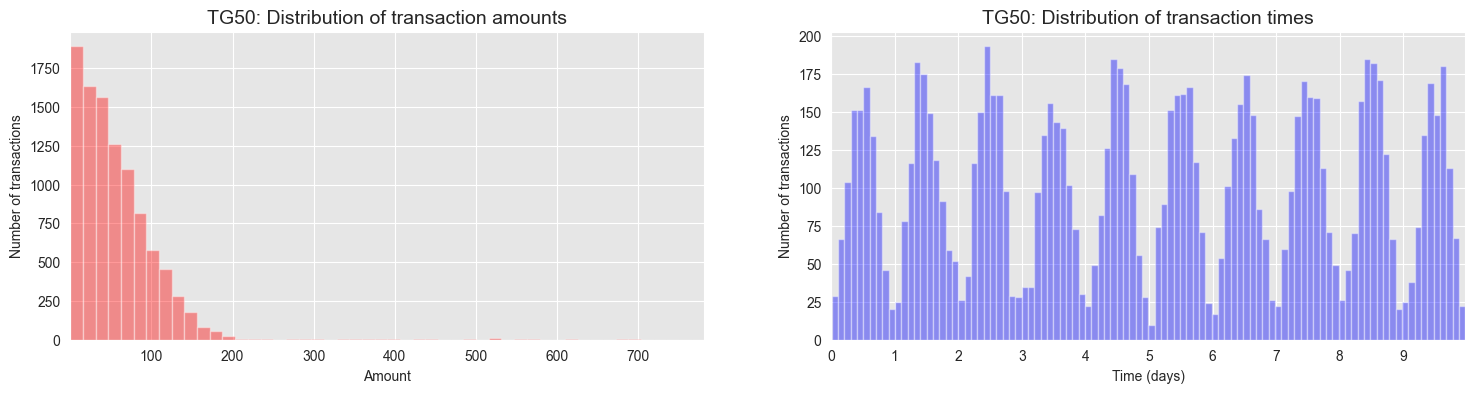

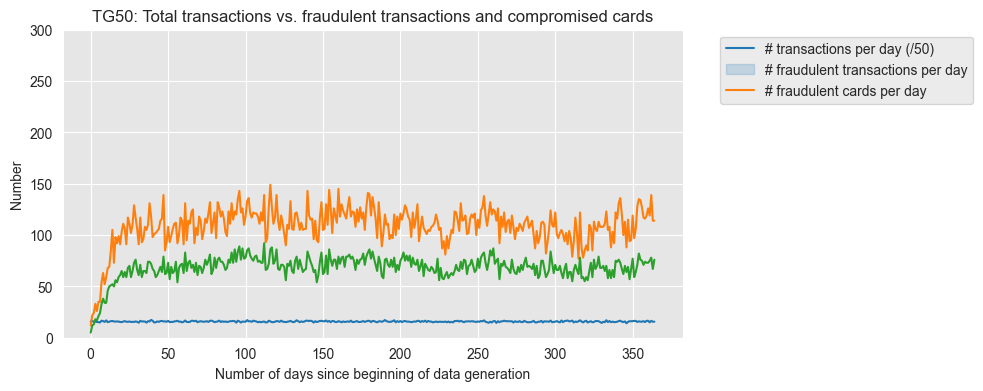

In [17]:
# Inserting the generated data in the Neo4j database named "TG50"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG50')

### Transaction Graph (100Mb)

In [18]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=820,
    n_terminals=820,
    nb_days=365,
    start_date="2023-03-01",
    r=5
)

Time to generate customer profiles table: 00:00:01
Time to generate terminal profiles table: 00:00:01
Time to associate terminals to customers: 00:00:45
Time to generate transactions: 00:41:78
Number of frauds from scenario 1: 296
Number of frauds from scenario 2: 36375
Number of frauds from scenario 3: 8742
Time to add fraudulent transactions: 01:11:40


Total storage size of data: 100.72 MB


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2866 [00:00<?, ?it/s]

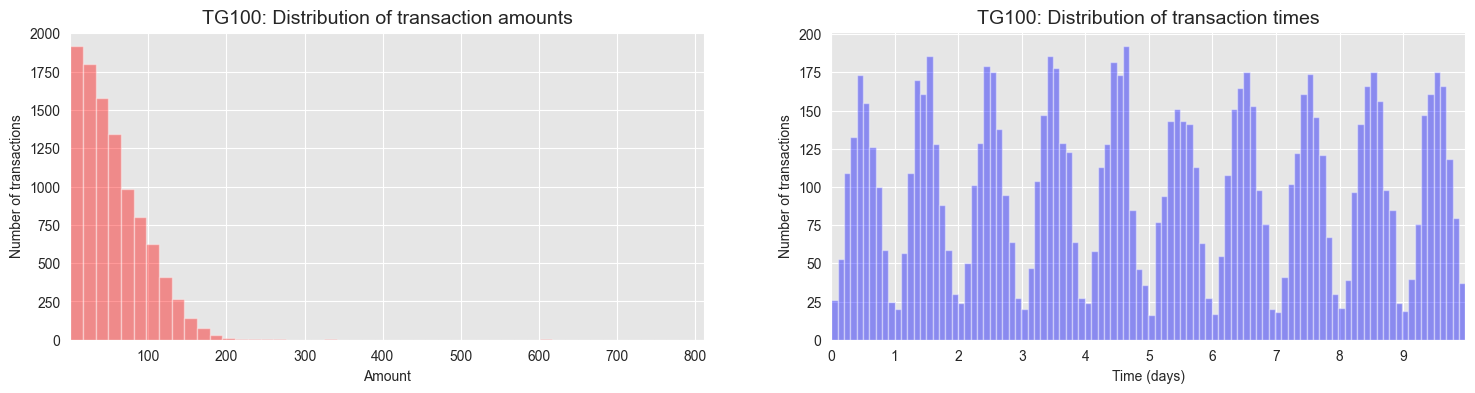

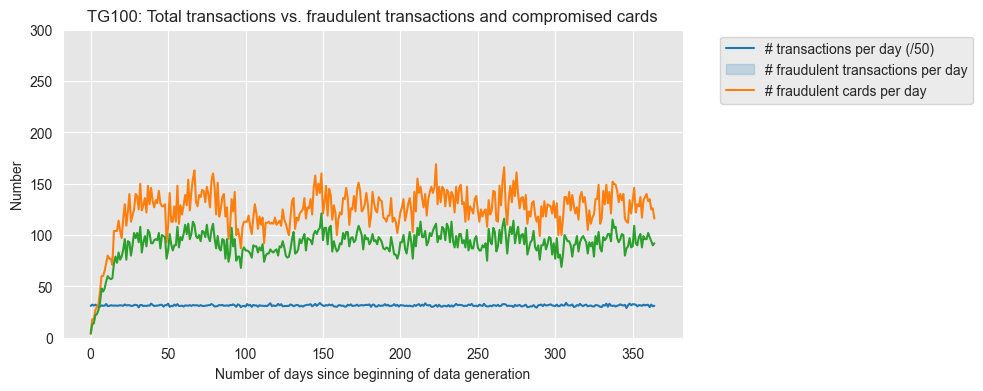

In [19]:
# Inserting the generated data in the Neo4j database named "TG100"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG100')

### Transaction Graph (200Mb)

In [20]:
# Generate the dataset using the simulator
(customer_profiles_table, terminal_profiles_table, transactions_df) = generate_dataset(
    n_customers=1620,
    n_terminals=1620,
    nb_days=365,
    start_date="2023-03-01",
    r=5
)

Time to generate customer profiles table: 00:00:03
Time to generate terminal profiles table: 00:00:01
Time to associate terminals to customers: 00:00:71
Time to generate transactions: 01:25:88
Number of frauds from scenario 1: 573
Number of frauds from scenario 2: 37002
Number of frauds from scenario 3: 9109
Time to add fraudulent transactions: 02:26:54


Total storage size of data: 199.17 MB


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5665 [00:00<?, ?it/s]

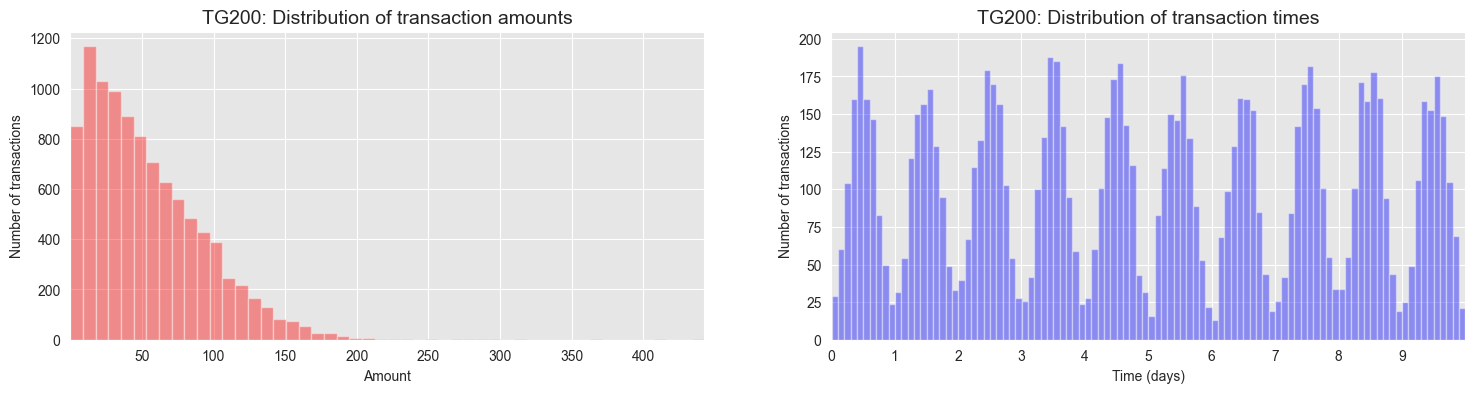

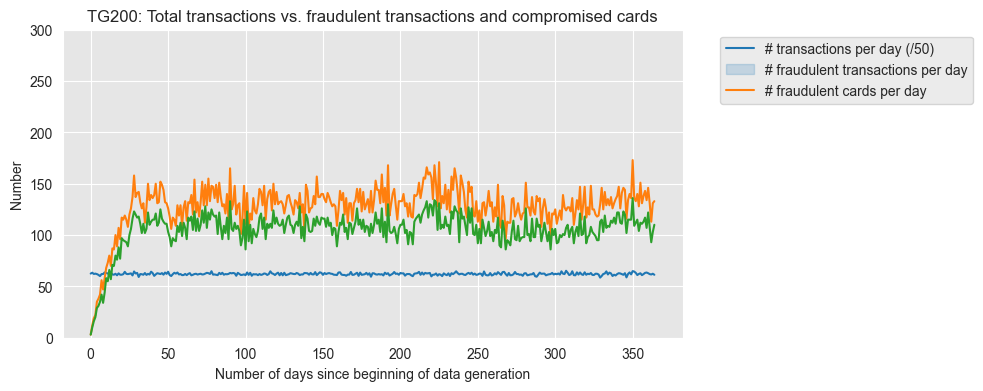

In [21]:
# Inserting the generated data in the Neo4j database named "TG200"
create_transaction_graph(customer_profiles_table, terminal_profiles_table, transactions_df, database='TG200')

## Execution Times

The execution times taken to import the generated datasets to each database are reported below:

In [22]:
for database, execution_time in db.create_execution_times.items():
    print(f"It took '{datetime.timedelta(seconds=round(execution_time))}' (HH:SS:mm) to insert data into '{database}'")

It took '0:02:31' (HH:SS:mm) to insert data into 'TG50'
It took '0:07:34' (HH:SS:mm) to insert data into 'TG100'
It took '0:25:11' (HH:SS:mm) to insert data into 'TG200'


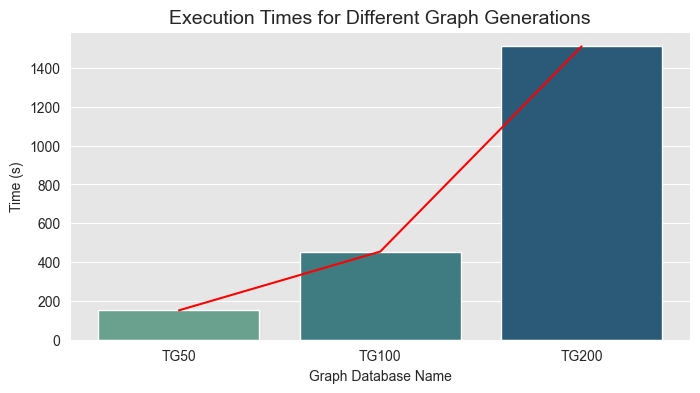

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=db.create_execution_times.keys(), y=db.create_execution_times.values(), ax=ax, palette='crest')
sns.lineplot(data=db.create_execution_times, ax=ax, color='red')
ax.set_title('Execution Times for Different Graph Generations', fontsize=14)
_ = ax.set(xlabel='Graph Database Name', ylabel='Time (s)')

# Experiments

Before proceeding with running different queries on our databases, we will create an indexing structure on the most demanding attributes of nodes and relationships to improve the performance.

In [16]:
for database in ['TGtest', 'TG50', 'TG100', 'TG200']:
    customer_index = 'CREATE INDEX customer_id_index IF NOT EXISTS FOR (n:Customer) ON (n.customer_id);'
    terminal_index = 'CREATE INDEX terminal_id_index IF NOT EXISTS FOR (n:Terminal) ON (n.terminal_id);'
    transaction_index = 'CREATE INDEX transaction_id_index IF NOT EXISTS FOR ()-[t:TRANSACTION]-() ON (t.terminal_id);'
    db.driver.execute_query(customer_index, database_=database)
    db.driver.execute_query(terminal_index, database_=database)
    db.driver.execute_query(transaction_index, database_=database)

In addition, since the `CALL apoc.periodic.iterate` operation improves performance by parallelization and batching, to benefit the fast responses as the datasets scale, we have to install APOC simply as described below in Neo4j Desktop:
- Open Neo4j Desktop
- Select `Manage` on the database of interest
- Open the `Plugins` tab
- Click `Install` in the `APOC` box and wait until you see a green check mark near "APOC"

## Performing Cypher Queries

As requested in the workload, there are 5 different queries that we will execute on our Neo4j graph database and evaluate their execution times accordingly on each of the generated datasets.

### Query (A)

**Query:** For each customer check that the spending frequency and the spending amounts of the last month are under the usual spending frequency and the spending amounts for the same period.

**Assumptions:**

- For this query, we should focus solely on transactions from the past month. As the generated dataset may span along various timeframes (past, present, and future), we can't simply use `today()`'s date as a reference point to capture transactions from the preceding month. Instead, we rely on the latest recorded transaction in the entire database, and we include transactions up to 31 days before that date.
- For a given customer $c$ and customer's set of transactions $t \in \{transactions\_last\_month\}$, we assume that:

  $spending\_frequency = count(t)$

  $spending\_amount = \sum_{t} t.tx\_amount$
  
- In order to compare such values with the *usual* spending frequency and amount of all customers $c \in C$ in the same period, we will compute $avg\_frequency$ and $avg\_amount$ as reference values to perform the comparison:

  $avg\_frequency = \frac{1}{|C|} \sum_{c \in C} c.spending\_frequency$

  $avg\_amount = \frac{1}{|C|} \sum_{c \in C} c.spending\_amount$

- In the end, for each $c \in C$, we will report whether or not $(c.spending\_frequency < avg\_frequency)$ and $(c.spending\_amount < avg\_amount)$.

In [51]:
query_A = '''
    MATCH ()-[t:TRANSACTION]->()
    WITH max(datetime(t.tx_datetime)) AS last_date
    
    MATCH (c:Customer)-[t:TRANSACTION]->(:Terminal)
    WHERE duration.inDays(datetime(t.tx_datetime), last_date).days < 31
    WITH
        c.customer_id AS customer_id,
        round(sum(t.tx_amount), 3) AS customer_transaction_amount,
        COUNT(t) AS customer_transaction_frequency
    WITH
        collect({
            id: customer_id,
            tx_amount: customer_transaction_amount,
            tx_freq: customer_transaction_frequency
        }) AS customer_details,
        round(avg(customer_transaction_amount), 3) AS average_transaction_amount,
        avg(customer_transaction_frequency) AS average_transaction_frequency
    UNWIND customer_details as cd
    RETURN
        cd.id AS customer_id,
        cd.tx_amount AS customer_transaction_amount,
        average_transaction_amount,
        cd.tx_freq AS customer_transaction_frequency,
        average_transaction_frequency,
        CASE
            WHEN cd.tx_amount < average_transaction_amount
            THEN 'Lower than average' ELSE 'Higher than average'
            END AS amount_comparison,
        CASE
            WHEN cd.tx_freq < average_transaction_frequency
            THEN 'Lower than average' ELSE 'Higher than average'
            END AS frequency_comparison
'''

In [52]:
df_A_50 = db.read_from_db(query_A, query_name='query_A', database='TG50')
df_A_100 = db.read_from_db(query_A, query_name='query_A', database='TG100')
df_A_200 = db.read_from_db(query_A, query_name='query_A', database='TG200')

The query returned 412 records in 1.601 s.
The query returned 811 records in 2.057 s.
The query returned 1609 records in 3.792 s.


In [53]:
df_A_50.head().rename(columns=lambda x: x.replace('_', '-'))

,customer-id,customer-transaction-amount,average-transaction-amount,customer-transaction-frequency,average-transaction-frequency,amount-comparison,frequency-comparison
0,0,4830.89,3514.779,74,59.223301,Higher than average,Higher than average
1,1,8429.35,3514.779,105,59.223301,Higher than average,Higher than average
2,2,4313.72,3514.779,56,59.223301,Higher than average,Lower than average
3,3,88.66,3514.779,5,59.223301,Lower than average,Lower than average
4,4,8029.89,3514.779,111,59.223301,Higher than average,Higher than average


### Query (B)

**Query:** For each terminal identify the possible fraudulent transactions. The fraudulent transactions are those whose import is higher than 20% of the maximum import of the transactions executed on the same terminal in the last month.

**Assumptions:**
- Similar to query (A), we obtain the latest transaction recorded in DB according to the previously mentioned reasons.
- To implement the query, we need to establish a `fraud_threshold` for each terminal. Initially, the description suggests setting the threshold as $0.2 \times \text{max}(t)$, resulting in numerous transactions $t \in \{terminal\_transactions\}$ being flagged as fraudulent. Instead, we propose setting the threshold as $0.8 \times \text{max}(t)$ to obtain only transactions with abnormal amounts for each terminal in the last month.

In [54]:
query_B = '''
    MATCH ()-[t:TRANSACTION]->()
    WITH max(datetime(t.tx_datetime)) AS last_date

    MATCH (:Customer)-[t:TRANSACTION]->(terminal:Terminal)
    WHERE duration.inDays(datetime(t.tx_datetime), last_date).days < 31
    WITH terminal, round(0.8 * max(t.tx_amount), 3) AS fraud_threshold, collect(t) AS transactions
    UNWIND transactions AS transaction
    WITH terminal, transaction, fraud_threshold
    WHERE transaction.tx_amount > fraud_threshold
    RETURN
        terminal.terminal_id AS terminal_id,
        transaction.transaction_id AS transaction_id,
        transaction.customer_id AS customer_id,
        transaction.tx_amount AS transaction_amount,
        fraud_threshold
'''

In [55]:
df_B_50 = db.read_from_db(query_B, query_name='query_B', database='TG50')
df_B_100 = db.read_from_db(query_B, query_name='query_B', database='TG100')
df_B_200 = db.read_from_db(query_B, query_name='query_B', database='TG200')

The query returned 1177 records in 1.355 s.
The query returned 2220 records in 1.904 s.
The query returned 4647 records in 4.053 s.


In [57]:
df_B_50.head().rename(columns=lambda x: x.replace('_', '-'))

,terminal-id,transaction-id,customer-id,transaction-amount,fraud-threshold
0,0,280662,399,131.01,123.928
1,0,278176,399,137.45,123.928
2,0,277885,399,154.91,123.928
3,2,283090,159,117.12,106.560
4,2,278847,15,133.20,106.560


### Query (C)

**Query:** Given a user $u$, determine the “co-customer-relationships $CC$ of degree $k$”. A user $u’$ is a co-customer of $u$ if you can determine a chain “$u_1-t_1-u_2-t_2-…t_{k-1}-u_k$“ such that $u_1=u$, $u_k=u’$, and for each $1 \leq i$ and $j \leq k$, $u_i<>u_j$, and $t_1,..t_{k-1}$ are the terminals on which a transaction has been executed. Therefore, $CC_k(u)=\{u’| \text{ a chain exists between } u \text{ and } u’ \text{ of degree } k\}$. Please, note that depending on the adopted model, the computation of $CC_k(u)$ could be quite complicated. Consider therefore at least the computation of $CC_3(u)$ (i.e. the co-costumer relationships of degree 3).

**Assumptions:**
- According to the query description, to identify $CC_3(u)$ on our graph database, we should look for subgraphs similar to the diagram drawn below, and identify such co-customers $c_1=u$, $c_3=u’$:
  
  ![CC3-diagram](images/CC3-diagram.png)

- To compute $CC_k(u)$, it has been mentioned that each customer should be traversed once only ($u_i<>u_j$). However, nothing has been mentioned for the traverse of the terminals, hence we assume that they can be traversed repeatedly.
- In most cases, there are several transactions present among each customer and the connected terminals (possibly hundreds or thousands). To make the query more efficient, since we are only interested in identifying $CC_3(u)$ relationships and not all the possible chains between $u$ and $u’$, we group our data by the start/end nodes of the chain and only report a single chain as a sample using `head(collect(...))`.

**Limitations:**
Unfortunately, using the following queries for pattern-matching, it was impossible to obtain any response even on the 50Mb database due to the shortage of memory and the complexity of the requested pattern.
- `MATCH (c1:Customer)-[:TRANSACTION*4]-(c2:Customer) RETURN c1, c2`
- `MATCH (c1:Customer)-[:TRANSACTION]->(t1:Terminal)<-[:TRANSACTION]-(c2:Customer)-[:TRANSACTION]->(t2:Terminal)<-[:TRANSACTION]-(c3:Customer) WHERE c1 <> c2 AND c1 <> c3 AND c2 <> c3 RETURN c1, c3`
As a result, we will report the query results and the performance separately below with two different patterns tested on a lighter database stored in `TGtest`:

In [59]:
query_C = '''
    MATCH (c1:Customer)-[:TRANSACTION]->(t1:Terminal)<-[:TRANSACTION]-(c2:Customer)-[:TRANSACTION]->(t2:Terminal)<-[:TRANSACTION]-(c3:Customer)
    WHERE c1 <> c2 AND c1 <> c3 AND c2 <> c3
    WITH
        c1,
        c3,
        head(collect({
            c2: c2.customer_id,
            t1: t1.terminal_id,
            t2: t2.terminal_id})
        ) as sample_chain
    RETURN
        c1.customer_id AS customer,
        c3.customer_id AS co_customer,
            "(c" + c1.customer_id + ")->(t" + sample_chain.t1
            + ")<-(c" + sample_chain.c2 + ")->(t" + sample_chain.t2
            + ")<-(c" + c3.customer_id + ")"
        AS sample_chain
'''

In [85]:
df_C = db.read_from_db(query_C, query_name='query_C', database='TGtest', store_exec_time=False)
df_C.head().rename(columns=lambda x: x.replace('_', '-'))

The query returned 54 records in 0.025 s.


,customer,co-customer,sample-chain
0,0,3,(c0)->(t4)<-(c1)->(t0)<-(c3)
1,0,4,(c0)->(t4)<-(c1)->(t0)<-(c4)
2,0,4,(c0)->(t4)<-(c1)->(t4)<-(c4)
3,0,1,(c0)->(t4)<-(c4)->(t4)<-(c1)
4,0,1,(c0)->(t4)<-(c4)->(t0)<-(c1)


In [61]:
query_C = '''
    MATCH (c1:Customer)-[:TRANSACTION]->(t1:Terminal)<-[:TRANSACTION]-(c2:Customer)-[:TRANSACTION]->(t2:Terminal)<-[:TRANSACTION]-(c3:Customer)
    WHERE c1 <> c2 AND c1 <> c3 AND c2 <> c3
    RETURN c1.customer_id AS customer, collect(distinct c3.customer_id)[0..5] as co_customers
'''

In [63]:
df_C = db.read_from_db(query_C, query_name='query_C', database='TGtest', store_exec_time=False)
df_C.head().rename(columns=lambda x: x.replace('_', '-'))

The query returned 4 records in 0.101 s.


,customer,co-customers
0,1,"[0, 3, 4]"
1,4,"[0, 3, 1]"
2,0,"[4, 3, 1]"
3,3,"[4, 0, 1]"


In [64]:
query_C = '''
    MATCH (c:Customer)-[t:TRANSACTION]->(tm:Terminal)
    WITH c, tm, head(collect(t)) as t
    WITH collect({
        c:c.customer_id, t:t.transaction_id, tm:tm.terminal_id
    }) as summarized_graph
    UNWIND summarized_graph AS depth1
    UNWIND summarized_graph AS depth2
    UNWIND summarized_graph AS depth3
    UNWIND summarized_graph AS depth4
    WITH
        depth1.c AS c1, depth1.t AS t1, depth1.tm AS tm1,
        depth2.c AS c2, depth2.t AS t2, depth2.tm AS tm2,
        depth3.c AS c3, depth3.t AS t3, depth3.tm AS tm3,
        depth4.c AS c4, depth4.t AS t4, depth4.tm AS tm4
    WHERE
        tm1=tm2 AND tm3=tm4 AND c2=c3
        AND c1<>c2 AND c1<>c4 AND c2<>c4
    RETURN
        c1 AS customer,
        c4 AS co_customer,
            "(c" + c1 + ")->(t" + tm1
            + ")<-(c" + c2 + ")->(t" + tm3
            + ")<-(c" + c4 + ")"
        AS sample_chain
'''

In [84]:
df_C = db.read_from_db(query_C, query_name='query_C', database='TGtest', store_exec_time=False)
df_C.head().rename(columns=lambda x: x.replace('_', '-'))

The query returned 54 records in 0.012 s.


,customer,co-customer,sample-chain
0,0,3,(c0)->(t4)<-(c1)->(t0)<-(c3)
1,0,4,(c0)->(t4)<-(c1)->(t0)<-(c4)
2,0,4,(c0)->(t4)<-(c1)->(t4)<-(c4)
3,0,1,(c0)->(t4)<-(c4)->(t4)<-(c1)
4,0,1,(c0)->(t4)<-(c4)->(t0)<-(c1)


As mentioned in the limitations, none of the queries above were capable of performing well on the scaled versions of the databases. The reason is, that there might be thousands of transactions between each customer and terminal, and directly applying the `MATCH` operation on the whole graph explodes, and also summarizing along with pattern-matching in the same query was reluctant to provide fast response. Therefore, we will proceed with another technique, described below:
- First, for each customer and terminal, if they are connected, we add a single new relationship between them labeled `:CONNECTED`.
- Then, instead of performing pattern-matching on `()-[:TRANSACTION]-()`, we will instead use `()-[:CONNECTED]-()` which will substantially decrease the runtime.
- The rest of the queries will be organized similarly as before.

In [38]:
query_C = '''
    CALL apoc.periodic.iterate(
        "MATCH (c:Customer)-[t:TRANSACTION]->(tm:Terminal)
        RETURN c, tm, count(t) as t",
        "MERGE (c)-[:CONNECTED]->(tm)",
        {batchSize:1000, iterateList:true}
    );
'''

In [39]:
_ = db.read_from_db(query_C, query_name='query_C', database='TG50')
_ = db.read_from_db(query_C, query_name='query_C', database='TG100')
_ = db.read_from_db(query_C, query_name='query_C', database='TG200')

The query returned 1 records in 0.794 s.
The query returned 1 records in 0.952 s.
The query returned 1 records in 1.318 s.


As we can see, the operation above is very fast. Now, we can easily query the chain of our interest using the `CONNECTED` relationships.

In [66]:
quer_C_read = '''
    MATCH (c1:Customer)-[:CONNECTED]->(t1:Terminal)<-[:CONNECTED]-(c2:Customer)-[:CONNECTED]->(t2:Terminal)<-[:CONNECTED]-(c3:Customer)
    WHERE c1 <> c2 AND c1 <> c3 AND c2 <> c3
    RETURN
        c1.customer_id AS customer,
        c3.customer_id AS co_customer,
            "(c" + c1.customer_id + ")->(t" + t1.terminal_id
            + ")<-(c" + c2.customer_id + ")->(t" + t2.terminal_id
            + ")<-(c" + c3.customer_id + ")"
        AS sample_chain
    LIMIT 5
'''

In [67]:
df_C_50 = db.read_from_db(quer_C_read, query_name='query_C', database='TG50', store_exec_time=False)
df_C_100 = db.read_from_db(quer_C_read, query_name='query_C', database='TG100', store_exec_time=False)
df_C_200 = db.read_from_db(quer_C_read, query_name='query_C', database='TG200', store_exec_time=False)

The query returned 5 records in 0.01 s.
The query returned 5 records in 0.006 s.
The query returned 5 records in 0.005 s.


In [83]:
df_C_50.head().rename(columns=lambda x: x.replace('_', '-'))

,customer,co-customer,sample-chain
0,399,1,(c399)->(t0)<-(c337)->(t378)<-(c1)
1,399,1,(c399)->(t0)<-(c337)->(t5)<-(c1)
2,337,1,(c337)->(t0)<-(c399)->(t378)<-(c1)
3,337,1,(c337)->(t0)<-(c399)->(t5)<-(c1)
4,337,385,(c337)->(t0)<-(c399)->(t270)<-(c385)


### Query (D)

**Query:** Extend the logical model that you have stored in the NOSQL database by introducing the
following information:
1. Each transaction should be extended with:
    - The period of the day {morning, afternoon, evening, night} in which the transaction has been executed.
    - The kind of products that have been bought through the transaction {hightech, food, clothing, consumable, other}
    - The feeling of security expressed by the user. This is an integer value between 1 and 5 expressed by the user when conclude the transaction. The values can be chosen randomly.
2. Customers that make more than three transactions from the same terminal expressing a similar average feeling of security should be connected as “buying_friends”. Therefore also this kind of relationship should be explicitly stored in the NOSQL database and can be queried. Note, two average feelings of security are considered similar when their difference is lower than 1.

We will proceed with each of the steps separately, distributing to queries `D1` and `D2` for the above tasks.

**Assumptions:**
- To obtain the period of the day, we utilize the transaction hours such that transactions within "00:00-06:00" are tagged "night", "06:00-12:00" as "morning", "12:00-18:00" as "afternoon", and "18:00-00:00" as "evening".
- For the kind of product purchased along the transaction, we assume that the products only belong to a single category among {"high-tech", "food", "clothing", "consumable", "other"}, which we randomly select and assign to each transaction. If we instead wanted to have a *list* of products for each transaction, we could create a list such that each entry (corresponding to a product) is randomly included or excluded. For example, `CASE WHEN rand()<0.5 THEN "high-tech" END`, and we repeat the same for all other products.
- Security feeling of the transaction is also drawn randomly and distributed as an integer number from 1 to 5.

#### Query (D1)

At first, the below query was used to update the transactions with a new set of values.

In [69]:
query_D1 = '''
    MATCH (:Customer)-[t:TRANSACTION]->(:Terminal)
    SET
        t.period_of_day = 
            CASE
                WHEN datetime(t.tx_datetime).hour >= 6 AND datetime(t.tx_datetime).hour < 12 THEN 'morning'
                WHEN datetime(t.tx_datetime).hour >= 12 AND datetime(t.tx_datetime).hour < 18 THEN 'afternoon'
                WHEN datetime(t.tx_datetime).hour >= 18 AND datetime(t.tx_datetime).hour < 24 THEN 'evening'
                ELSE 'night'
            END,
        t.product = 
            ["high-tech", "food", "clothing", "consumable", "other"]
            [toInteger(round(rand() * 4))],
        t.security_feeling = toInteger(round(rand() * 4) + 1)

    RETURN
        t.transaction_id, t.customer_id, t.terminal_id, t.tx_datetime,
        t.period_of_day, t.product, t.security_feeling
    LIMIT 5
'''

The query above, however, failed to provide fast responses as the dataset scaled. To overcome this issue, we optimized the query and utilized `CALL apoc.periodic.iterate` to improve the performance by parallelization and batching. We will now try to obtain the same result without using `CASE` expressions, using array indexing techniques, to check whether it improves the performance of the query or not.

In [24]:
query_D1 = '''
    CALL apoc.periodic.iterate(
        "MATCH (:Customer)-[t:TRANSACTION]->(:Terminal)
        RETURN t, datetime(t.tx_datetime).hour/6 AS period_index, toInteger(round(rand()*4)) AS random_index",
        "SET
            t.period_of_day = ['night', 'morning', 'afternoon', 'evening'][period_index],
            t.product = ['high-tech', 'food', 'clothing', 'consumable', 'other'][random_index],
            t.security_feeling = random_index + 1",
      {batchSize:1000, iterateList:true}
    );
'''

In [23]:
_ = db.read_from_db(query_D1, query_name='query_D1', database='TG50')
_ = db.read_from_db(query_D1, query_name='query_D1', database='TG100')
_ = db.read_from_db(query_D1, query_name='query_D1', database='TG200')

The query returned 1 records in 5.047 s.
The query returned 1 records in 10.589 s.
The query returned 1 records in 17.857 s.


As an example, we will now report the first 5 transactions with the updated properties:

In [70]:
query_D1_read = '''
    MATCH (:Customer)-[t:TRANSACTION]->(:Terminal)
    RETURN
        t.transaction_id, t.customer_id, t.terminal_id, t.tx_datetime,
        t.period_of_day, t.product, t.security_feeling
    LIMIT 5
'''

In [71]:
df_D1 = db.read_from_db(query_D1_read, query_name='query_D1', database='TG50', store_exec_time=False)
df_D1.rename(columns=lambda x: x.replace('_', '-'))

The query returned 5 records in 0.016 s.


,t.transaction-id,t.customer-id,t.terminal-id,t.tx-datetime,t.period-of-day,t.product,t.security-feeling
0,90003,399,0,2018-07-24T06:11:36.000000000,morning,food,2
1,287621,337,0,2019-03-31T18:59:28.000000000,evening,high-tech,1
2,285340,337,0,2019-03-29T01:25:16.000000000,night,clothing,3
3,284817,337,0,2019-03-28T09:33:46.000000000,morning,clothing,3
4,281994,399,0,2019-03-24T16:22:42.000000000,afternoon,consumable,4


#### Query (D2)

In a separate query, we attempt to add `BUYING_FRIEND` relationships. We find customers with +3 transactions on the same terminal, computing their average security feeling separately, and connect them if their feelings is similar.

  ![buying_friends](images/buying-friends-diagram.png)

At first, the query below was provided the insert the additional `BUYING_FRIEND` relationships in the database.

In [ ]:
query_D2 = '''
    MATCH (c1:Customer)-[t1:TRANSACTION]->(tm1:Terminal)
    WITH c1, tm1, COUNT(t1) AS n_transactions_c1, avg(t1.security_feeling) AS avg_security_t1
    WHERE n_transactions_c1 > 3
    
    MATCH (c2:Customer)-[t2:TRANSACTION]->(tm2:Terminal)
    WITH c2, tm2, COUNT(t2) AS n_transactions_c2, avg(t2.security_feeling) AS avg_security_t2, c1, tm1, avg_security_t1
    WHERE n_transactions_c2 > 3 AND tm1=tm2 AND c1<>c2
        AND ABS(avg_security_t2 - avg_security_t1) < 1
    
    MERGE (c1)-[:BUYING_FRIEND]->(c2)
    
    RETURN
        c1.customer_id, c2.customer_id,
        tm2.terminal_id AS terminal,
        avg_security_t1, avg_security_t2
'''

However, it failed to provide a response, again due to the shortage of memory and not being optimized. Using `CALL apoc.periodic.iterate` along with an optimized version of the query, we will try to solve the problem as below

In [25]:
query_D2 = '''
    CALL apoc.periodic.iterate(
        "MATCH (c:Customer)-[t:TRANSACTION]->(tm:Terminal)
        WITH c, tm, COUNT(t) AS n_transactions, avg(t.security_feeling) AS avg_security
        WHERE n_transactions > 3
        WITH collect({customer: c, terminal: tm, avg_security: avg_security}) AS pairs
        UNWIND pairs AS p1
        UNWIND pairs AS p2
        WITH
            p1.customer AS c1, p1.terminal AS tm1, p1.avg_security AS avg_sec1,
            p2.customer AS c2, p2.terminal AS tm2, p2.avg_security AS avg_sec2
        WHERE c1<>c2 AND tm1=tm2 AND ABS(avg_sec1 - avg_sec2) < 1
        RETURN c1, c2",
        "MERGE (c1)-[:BUYING_FRIEND]->(c2)",
      {batchSize:1000, iterateList:true}
    );
'''

In [26]:
_ = db.read_from_db(query_D2, query_name='query_D2', database='TG50')
_ = db.read_from_db(query_D2, query_name='query_D2', database='TG100')
_ = db.read_from_db(query_D2, query_name='query_D2', database='TG200')

The query returned 1 records in 1.665 s.
The query returned 1 records in 13.572 s.
The query returned 1 records in 248.687 s.


To confirm that the relationships have been created, we will select a few of them as below:

In [72]:
query_D2_read = '''
    MATCH (c1:Customer)-[bf:BUYING_FRIEND]->(c2:Customer)
    RETURN c1.customer_id, type(bf) AS relationship_type, c2.customer_id
    LIMIT 5
'''

In [87]:
df_D2 = db.read_from_db(query_D2_read, query_name='query_D2_read', database='TG50', store_exec_time=False)
df_D2['relationship_type'] = df_D2['relationship_type'].str.replace('_', '-')
df_D2.rename(columns=lambda x: x.replace('_', '-'))

The query returned 5 records in 0.004 s.


,c1.customer-id,relationship-type,c2.customer-id
0,34,BUYING-FRIEND,0
1,385,BUYING-FRIEND,0
2,154,BUYING-FRIEND,0
3,341,BUYING-FRIEND,0
4,134,BUYING-FRIEND,0


![buying_friends](images/buying-friends.png)

### Query (E)

**Query:** For each period of the day identify the number of transactions that occurred in that period, and the average number of fraudulent transactions.

**Assumptions:** In order to compute the average number of fraudulent transactions, we use the `tx_fraud` property as a reference.

In [76]:
query_E = '''
    MATCH (:Customer)-[t:TRANSACTION]-(:Terminal)
    RETURN
        t.period_of_day AS period_of_day,
        count(t) AS transaction_count,
        round(avg(t.tx_fraud), 3) AS fraud_percentage
'''

In [77]:
df_E_50 = db.read_from_db(query_E, query_name='query_E', database='TG50')
df_E_100 = db.read_from_db(query_E, query_name='query_E', database='TG100')
df_E_200 = db.read_from_db(query_E, query_name='query_E', database='TG200')

The query returned 4 records in 1.165 s.
The query returned 4 records in 0.767 s.
The query returned 4 records in 1.692 s.


The table below demonstrates the fraud percentage for each period of the day in the `TG200` database.

In [78]:
df_E_200.rename(columns=lambda x: x.replace('_', '-'))

,period-of-day,transaction-count,fraud-percentage
0,evening,145601,0.042
1,afternoon,420391,0.041
2,morning,421718,0.041
3,night,145280,0.041


## Execution Times

The execution times taken to perform each of the queries mentioned above on all the graph databases are summarized below (in seconds):

In [79]:
df_exec_times = pd.DataFrame(db.read_execution_times)
df_exec_times.rename(columns=lambda x: x.replace('_', '-'))

,query-D1,query-D2,query-C,query-A,query-B,query-E
TG50,5.047,1.665,2.143,1.601,1.355,1.165
TG100,10.589,13.572,0.094,2.057,1.904,0.767
TG200,17.857,248.687,0.102,3.792,4.053,1.692


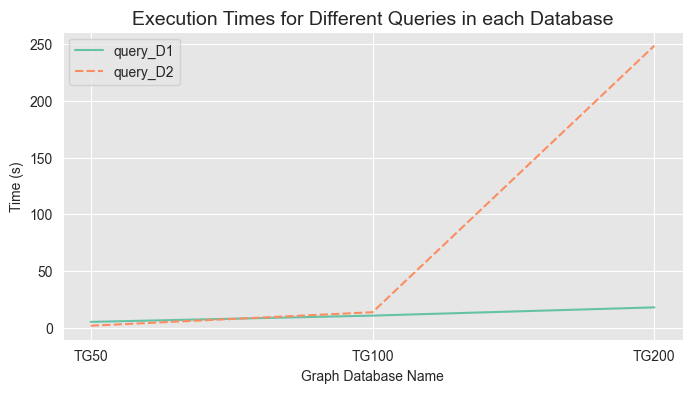

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=df_exec_times, ax=ax, palette='Set2')
ax.set_title('Execution Times for Different Queries in each Database', fontsize=14)
_ = ax.set(xlabel='Graph Database Name', ylabel='Time (s)')